# NHL Forward Clustering

This file is used to cluster NHL forwards into different tiers.

## Import Libraries

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Forward Clustering

In [112]:
# Load Forwards
nhl_forwards = pd.read_csv('../dataset/preprocess/nhl_forwards.csv')

In [113]:
nhl_forwards

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,nation,height_cm,weight_kg,shoots,player_type,nhl_rights,draft,highlights,description,age_by_2025
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,Canada,180,88,L,NaN,NaN,"('1', '15', '1987')","['1-time U20 WJC Gold Medal', '1-time World Ch...",Brother: Brian Sakic\r\nSons: Chase Sakic & Mi...,56
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,Sweden,185,93,L,"['Cerebral Tactician', 'Playmaker', 'Two-Way C...",NaN,"('1', '6', '1991')","['1-time TV-Pucken Gold Medal', '1-time J18 SM...",Arguably the greatest Swedish forward to ever ...,52
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,Czechia / USA,183,87,R,['Sniper'],NaN,"('4', '87', '1994')","['1-time Olympic Gold Medal', '1-time World Ch...",Father: Milan Hejduk\r\nCousin: Tomas Hejduk\r...,49
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,Canada,185,88,L,['Playmaker'],NaN,"('1', '12', '1998')","['1-time CHL All-Rookie Team', '1-time NHL Sta...",Brother: Maxime Tanguay\r\nCousin: Tyler Tangu...,45
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,USA,178,86,R,NaN,NaN,"('3', '72', '1994')","['2-time Olympic Silver Medal', '1-time World ...",Son: Luke Drury\r\nBrothers: Ted Drury & Jim D...,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,3869.0,Dean Sylvester,3,2,96.0,1.0,52.0,21.0,16.0,37.0,...,USA,188,91,R,NaN,NaN,NaN,[],"Brothers: Evan Sylvester, Todd Sylvester",52
1600,3870.0,Mike Sullivan,11,11,709.0,19.0,81.0,54.0,82.0,136.0,...,USA,188,84,L,NaN,NaN,"('4', '69', '1987')",[],Son: Matt Sullivan\r\nSon-in-law: Charlie McAvoy,57
1601,3880.0,Jean-Pierre Vigier,6,5,213.0,2.0,72.0,23.0,23.0,46.0,...,Canada,182,86,R,NaN,NaN,NaN,"['1-time AHL Calder Cup Champion', '1-time AHL...","Cousins: Ian Vigier, Stephan Vigier",49
1602,3897.0,Viktor Tikhonov,2,2,111.0,11.0,61.0,11.0,11.0,22.0,...,Russia,187,87,R,NaN,NaN,"('1', '28', '2008')","['1-time World Championship Gold Medal', '1-ti...",Tikhonov is a forward with fine offensive abil...,37


## Processing Stats Attributes (numeric)

- Select numeric columns

- Standardize them

In [114]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
stats_cols = [
    "gp_regular_total", "gp_regular_min_per_season", "gp_regular_max_per_season",
    "g_regular_sum", "a_regular_sum", "p_regular_sum", "plus_minus_regular_sum", "pim_regular_sum",
    "ppg_regular_sum", "ppp_regular_sum", "shg_regular_sum", "shp_regular_sum",
    "gwg_regular_sum", "otg_regular_sum", "sog_regular_sum",
    "shooting_pct_regular_mean", "fo_pct_regular_mean", "toi_per_game_regular_mean",
    "g_regular_per_game", "a_regular_per_game", "p_regular_per_game",
    "sog_regular_per_game", "pim_regular_per_game",
    "gp_playoffs_sum", "g_playoffs_sum", "a_playoffs_sum", "p_playoffs_sum", "plus_minus_playoffs_sum", "pim_playoffs_sum",
    "ppg_playoffs_sum", "ppp_playoffs_sum", "shg_playoffs_sum", "shp_playoffs_sum",
    "gwg_playoffs_sum", "otg_playoffs_sum", "sog_playoffs_sum",
    "shooting_pct_playoffs_mean", "fo_pct_playoffs_mean", "toi_per_game_playoffs_mean",
    "g_playoffs_per_game", "a_playoffs_per_game", "p_playoffs_per_game",
    "sog_playoffs_per_game", "pim_playoffs_per_game"
]

# Fill missing values with 0
nhl_forwards[stats_cols] = nhl_forwards[stats_cols].fillna(0)

# Standardize the data
scaler = StandardScaler()
X_stats_scaled = scaler.fit_transform(nhl_forwards[stats_cols])

## Categorical Encoding

- `nation`, `shoots`, `player_pos_official`, `player_type` -> One-hot encoding

- `draft`

    - Convert to structured features: round, overall, year

- `highlights`, `description` -> Textual features (not used in clustering)

In [115]:
# Handle Nation and Shoots by One-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot_cols = ["nation", "shoots", "player_pos_official"]
ohe = OneHotEncoder(handle_unknown='ignore')
X_onehot = ohe.fit_transform(nhl_forwards[onehot_cols])

In [116]:
# Handle Player Type
import ast

# Step 1: Ensure player_type column is always a list
def parse_types(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)  # safely evaluate string representation of list
        except (ValueError, SyntaxError):
            return [x.strip()] if x.strip() else []
    return []

nhl_forwards['player_type'] = nhl_forwards['player_type'].apply(parse_types)

# Step 2: Get all unique player types
all_types = sorted(set(pt for types in nhl_forwards['player_type'] for pt in types))

# Step 3: One-hot encode player types
for pt in all_types:
    col_name = f"player_type_{pt.replace(' ', '_').lower()}"
    nhl_forwards[col_name] = nhl_forwards['player_type'].apply(lambda x: int(pt in x))

# Step 4: Select the one-hot encoded columns
X_player_type = nhl_forwards[[col for col in nhl_forwards.columns if col.startswith("player_type_")]]

In [117]:
# Handle Draft
nhl_forwards['draft_round'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[0]) if pd.notnull(x) else None)
nhl_forwards['draft_overall'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[1]) if pd.notnull(x) else None)
nhl_forwards['draft_year'] = nhl_forwards['draft'].dropna().apply(lambda x: int(eval(x)[2]) if pd.notnull(x) else None)


In [118]:
# Extract Draft Features into X_draft
draft_cols = ['draft_round', 'draft_overall', 'draft_year']
X_draft = nhl_forwards[draft_cols]

In [119]:
nhl_forwards

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,player_type_puckhandler,player_type_role_player,player_type_sniper,player_type_speedster,player_type_two-way_center,player_type_two-way_forward,player_type_workhorse,draft_round,draft_overall,draft_year
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,0,0,0,0,0,0,0,1.0,15.0,1987.0
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,0,0,0,0,1,0,0,1.0,6.0,1991.0
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,0,1,0,0,0,0,4.0,87.0,1994.0
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,0,0,0,0,0,0,0,1.0,12.0,1998.0
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,0,0,0,0,0,0,0,3.0,72.0,1994.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,3869.0,Dean Sylvester,3,2,96.0,1.0,52.0,21.0,16.0,37.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1600,3870.0,Mike Sullivan,11,11,709.0,19.0,81.0,54.0,82.0,136.0,...,0,0,0,0,0,0,0,4.0,69.0,1987.0
1601,3880.0,Jean-Pierre Vigier,6,5,213.0,2.0,72.0,23.0,23.0,46.0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1602,3897.0,Viktor Tikhonov,2,2,111.0,11.0,61.0,11.0,11.0,22.0,...,0,0,0,0,0,0,0,1.0,28.0,2008.0


### Handle Highlights

1. Normalize the highlights columns

2. Extract Award Features

3. Aggregate to General Award Metrics

In [120]:
import re

# Define NHL-related awards
award_keywords = {
    "calder": "Calder Trophy",         # Rookie award
    "conn_smythe": "Conn Smythe Trophy", # Playoff MVP
    "hart": "Hart Trophy",             # Season MVP
    "selke": "Selke Trophy",           # Best Defensive Forward award
    "lindsay": "Lindsay Award",
    "all_star_first": "First All-Star Team",
    "all_star_second": "Second All-Star Team",
    "stanley_cup": "Stanley Cup Champion",
    "hhof": "Hockey Hall of Fame"      # Lifetime award
}

def extract_awards(awards_list):
    """Count NHL-related awards for a player."""
    award_counts = {key: 0 for key in award_keywords.keys()}

    if pd.isna(awards_list):
        return award_counts

    # Convert stringified list to list if necessary
    if isinstance(awards_list, str):
        try:
            awards_list = eval(awards_list)
        except:
            awards_list = [awards_list]

    for award in awards_list:
        text = str(award).lower()
        for key, phrase in award_keywords.items():
            if phrase.lower() in text:
                # Check for counts like "5-time" or "2-time"
                match = re.search(r"(\d+)[- ]?time", text)
                count = int(match.group(1)) if match else 1
                award_counts[key] += count

    return award_counts

# Apply the function to the highlights column
award_features = nhl_forwards['highlights'].apply(extract_awards).apply(pd.Series)

# Merge the award counts back into the main dataframe
nhl_forwards = pd.concat([nhl_forwards, award_features], axis=1)

# Fill NaNs with 0 for awards
nhl_forwards[award_features.columns] = nhl_forwards[award_features.columns].fillna(0)

# Show the first 5 players
nhl_forwards.head()

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,draft_year,calder,conn_smythe,hart,selke,lindsay,all_star_first,all_star_second,stanley_cup,hhof
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,1987.0,0,1,1,0,1,4,1,2,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,1991.0,1,0,1,0,0,3,0,2,1
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,1994.0,0,0,0,0,0,0,1,1,0
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,1998.0,0,0,0,0,0,0,0,1,0
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,1994.0,1,0,0,0,0,0,0,1,1


In [121]:
# Extract Award Features into X_highlights
award_cols = award_features.columns

X_highlights = nhl_forwards[award_cols]

## Combine All Features

In [122]:
from scipy.sparse import hstack

# Combine all features
X_combined = hstack([X_stats_scaled, X_onehot, X_player_type, X_draft, X_highlights]).toarray()

## Dimensionality Reduction

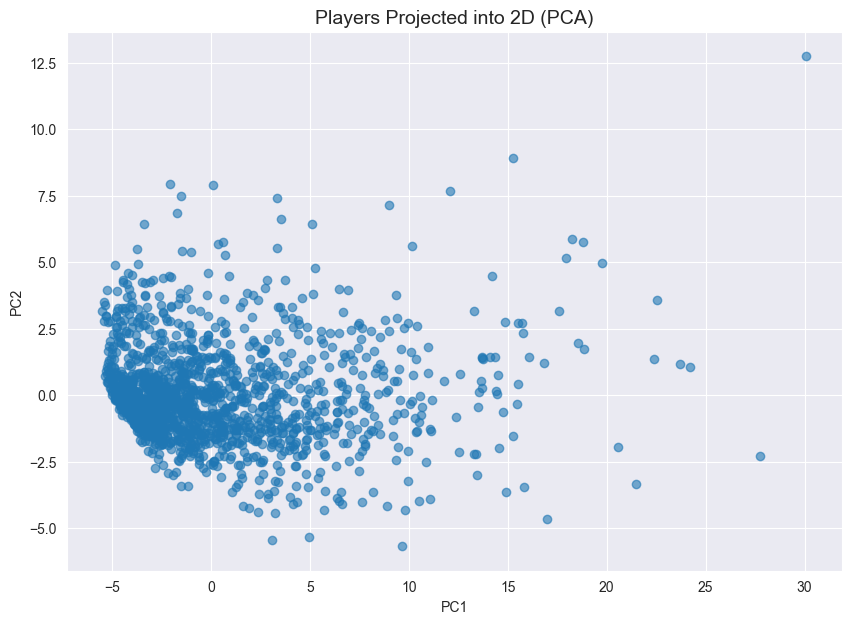

In [123]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (PCA)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


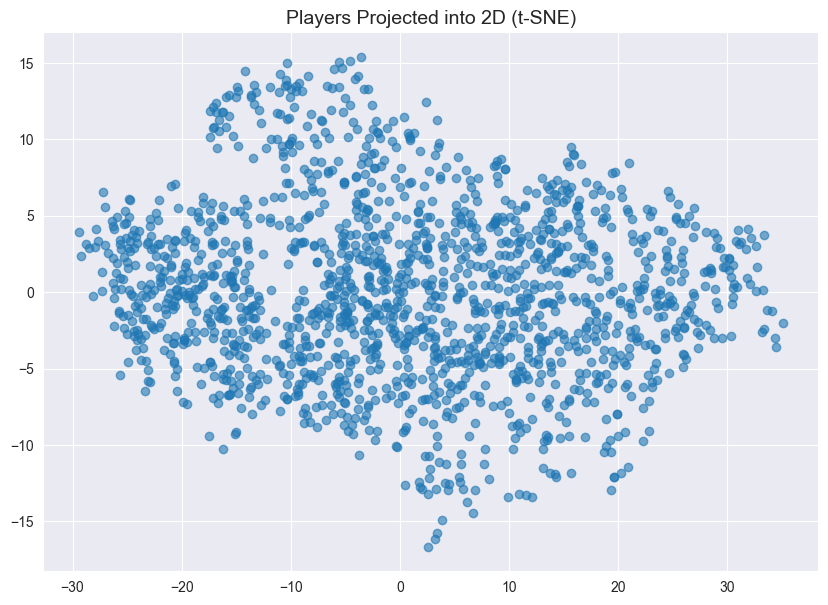

In [124]:
from sklearn.manifold import TSNE

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

X_tsne = TSNE(n_components=3, perplexity=30, random_state=42).fit_transform(X_dense)

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6)
plt.title("Players Projected into 2D (t-SNE)", fontsize=14)
plt.show()

## Clustering

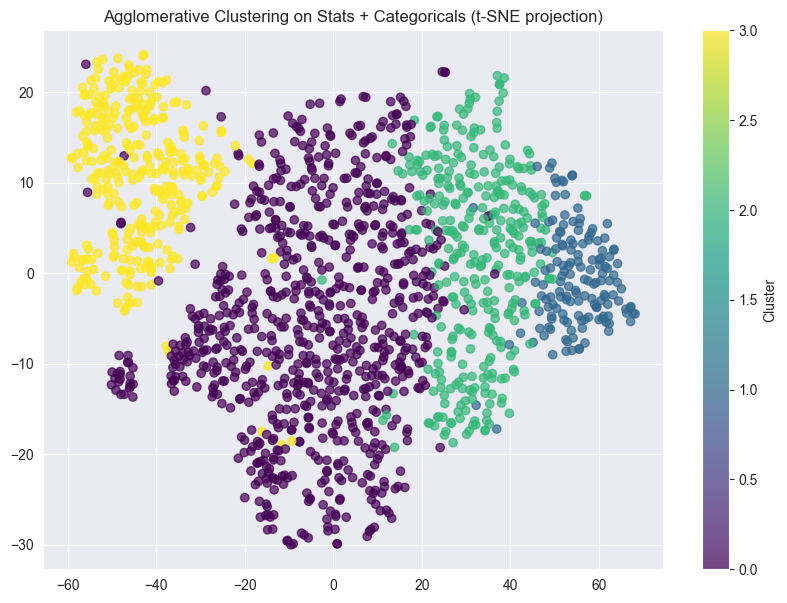

In [125]:
from scipy.sparse import hstack
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Combine numeric (scaled), categorical (one-hot), and maybe highlights
X_combined = hstack([X_stats_scaled, X_onehot, X_highlights])

# AgglomerativeClustering does not accept sparse matrices -> convert to dense
X_dense = X_combined.toarray()

# Step 2: Cluster in high-dimensional space
agg = AgglomerativeClustering(n_clusters=4)
labels = agg.fit_predict(X_dense)

# Add cluster labels back to DataFrame
nhl_forwards['cluster'] = labels

# Step 3: Project to 2D with t-SNE for visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(X_dense)

# Step 4: Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (t-SNE projection)")
plt.show()

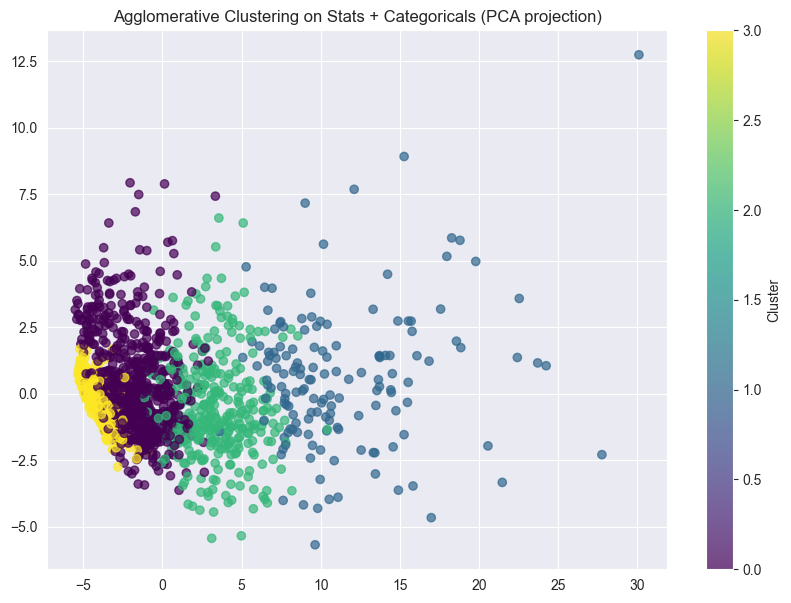

In [126]:
# Plot the clustering result using PCA
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("Agglomerative Clustering on Stats + Categoricals (PCA projection)")
plt.show()

In [127]:
# Show the average p_regular_per_season for each cluster
nhl_forwards.groupby('cluster')['p_regular_per_season'].mean()

cluster
0    16.637606
1    56.763057
2    38.205591
3    10.002450
Name: p_regular_per_season, dtype: float64

In [128]:
# Assign cluster labels to tiers
nhl_forwards['tier'] = nhl_forwards['cluster'].map({
    0: 3, # Tier 3
    1: 1, # Tier 1
    2: 2, # Tier 2
    3: 4  # Tier 4
})

# nhl_forwards['tier'] = nhl_forwards['cluster'].map({
#     0: 1, # Tier 1
#     1: 3, # Tier 2
#     2: 2, # Tier 3
#     3: 4,  # Tier 4
#     4: 5  # Tier 5
# })

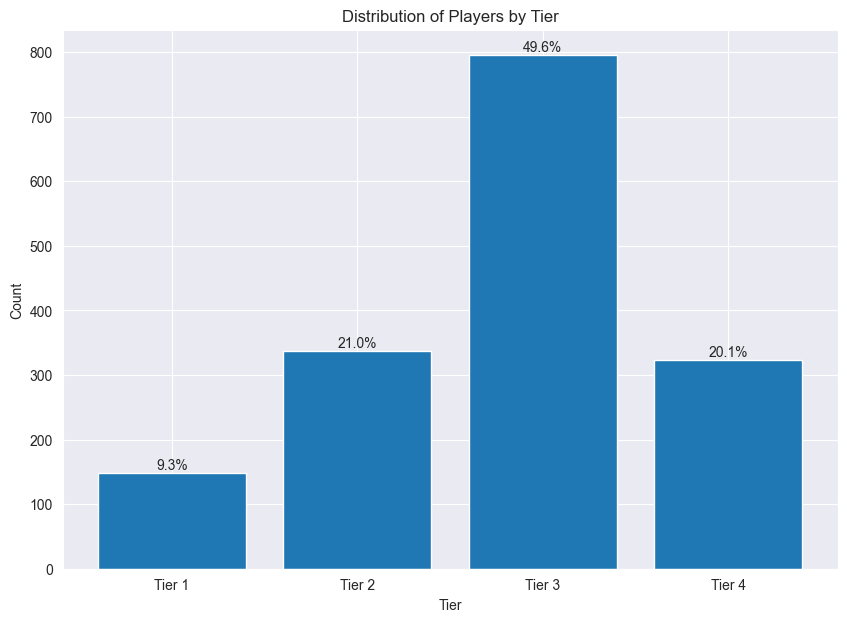

In [129]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_forwards['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_forwards) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [130]:
# Find Sidney Crosby's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Sidney Crosby']['tier'].values[0]

np.int64(1)

In [131]:
# Find Jarome Iginla's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Jarome Iginla']['tier'].values[0]

np.int64(1)

## Further Clustering Tier 1 Forwards

Tier 1 Forwards count: 149
Feature dimensions: (149, 136)


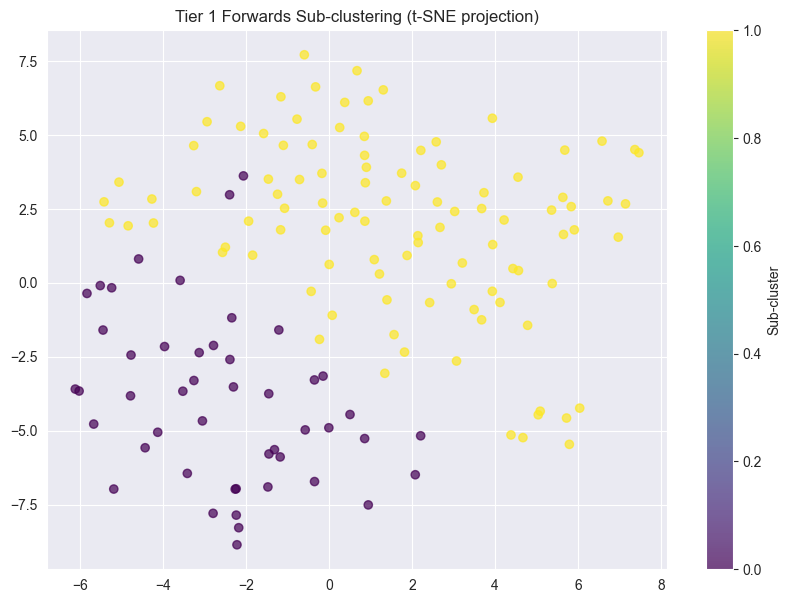

In [132]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get tier 1 forwards indices
tier_1_indices = nhl_forwards[nhl_forwards['tier'] == 1].index

# Extract the corresponding features
X_tier_1 = X_dense[tier_1_indices]

print(f"Tier 1 Forwards count: {len(tier_1_indices)}")
print(f"Feature dimensions: {X_tier_1.shape}")

# Perform sub-clustering into 3 groups
agg_tier1 = AgglomerativeClustering(n_clusters=2)
tier1_labels = agg_tier1.fit_predict(X_tier_1)

# Create sub-tiers (1a, 1b, 1c)
tier_1_forwards = nhl_forwards.loc[tier_1_indices].copy()
# Map cluster labels to sub-tier names
label_map = {0: '1a', 1: '1b'}
tier_1_forwards['sub_tier'] = pd.Series(tier1_labels, index=tier_1_forwards.index).map(label_map)


# Visualize the sub-clustering with t-SNE
X_tier1_tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=min(30, len(tier_1_indices)//3)
).fit_transform(X_tier_1)

plt.figure(figsize=(10, 7))
plt.scatter(X_tier1_tsne[:, 0], X_tier1_tsne[:, 1], c=tier1_labels, cmap="viridis", alpha=0.7)
plt.colorbar(label='Sub-cluster')
plt.title("Tier 1 Forwards Sub-clustering (t-SNE projection)")
plt.show()


In [133]:
# Show the average p_regular_per_season for each cluster
tier_1_forwards.groupby('sub_tier')['p_regular_per_season'].mean()

sub_tier
1a    68.778113
1b    51.052931
Name: p_regular_per_season, dtype: float64

In [134]:
# Change tier 1b to tier 2
nhl_forwards.loc[tier_1_forwards[tier_1_forwards['sub_tier'] == '1b'].index, 'tier'] = 2

# Remove sub_tier
tier_1_forwards.drop(['sub_tier'], axis=1, inplace=True)

nhl_forwards

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,conn_smythe,hart,selke,lindsay,all_star_first,all_star_second,stanley_cup,hhof,cluster,tier
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,1,1,0,1,4,1,2,1,1,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,0,1,0,0,3,0,2,1,1,1
2,3.0,Milan Hejduk,14,14,1020.0,29.0,82.0,375.0,430.0,805.0,...,0,0,0,0,0,1,1,0,1,2
3,4.0,Alex Tanguay,16,16,1088.0,16.0,82.0,283.0,580.0,863.0,...,0,0,0,0,0,0,1,0,2,2
4,5.0,Chris Drury,12,12,892.0,24.0,82.0,255.0,360.0,615.0,...,0,0,0,0,0,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,3869.0,Dean Sylvester,3,2,96.0,1.0,52.0,21.0,16.0,37.0,...,0,0,0,0,0,0,0,0,3,4
1600,3870.0,Mike Sullivan,11,11,709.0,19.0,81.0,54.0,82.0,136.0,...,0,0,0,0,0,0,0,0,0,3
1601,3880.0,Jean-Pierre Vigier,6,5,213.0,2.0,72.0,23.0,23.0,46.0,...,0,0,0,0,0,1,0,0,3,4
1602,3897.0,Viktor Tikhonov,2,2,111.0,11.0,61.0,11.0,11.0,22.0,...,0,0,0,0,1,0,0,0,3,4


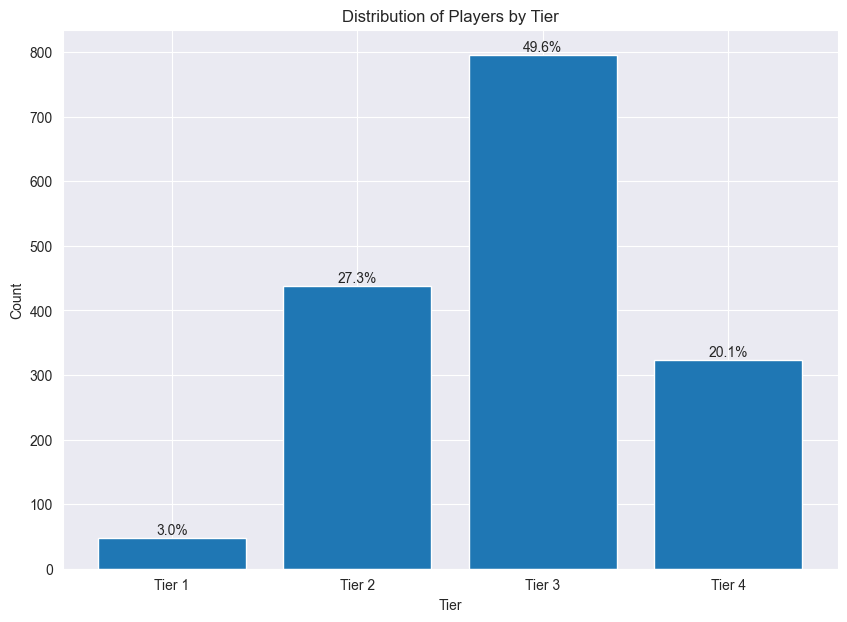

In [135]:
import matplotlib.pyplot as plt

# Calculate counts and percentages
tier_counts = nhl_forwards['tier'].value_counts().sort_index()
tier_percentages = tier_counts / len(nhl_forwards) * 100

# Plot bar chart instead of histogram
plt.figure(figsize=(10, 7))
bars = plt.bar(tier_counts.index, tier_counts.values, tick_label=[f"Tier {i}" for i in tier_counts.index])

# Annotate with percentages
for bar, pct in zip(bars, tier_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{pct:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Players by Tier")
plt.xlabel("Tier")
plt.ylabel("Count")
plt.show()

In [136]:
# Find Sidney Crosby's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Sidney Crosby']['tier'].values[0]

np.int64(1)

In [137]:
# Find Jarome Iginla's Tier
nhl_forwards[nhl_forwards['player_name_official'] == 'Jarome Iginla']['tier'].values[0]

np.int64(2)

In [138]:
# Show Tier 1 Forwards
nhl_forwards[nhl_forwards['tier'] == 1]

,player_id,player_name_official,seasons_played,seasons_with_gp_over_6,gp_regular_total,gp_regular_min_per_season,gp_regular_max_per_season,g_regular_sum,a_regular_sum,p_regular_sum,...,conn_smythe,hart,selke,lindsay,all_star_first,all_star_second,stanley_cup,hhof,cluster,tier
0,1.0,Joe Sakic,20,20,1378.0,15.0,84.0,625.0,1016.0,1641.0,...,1,1,0,1,4,1,2,1,1,1
1,2.0,Peter Forsberg,13,12,708.0,2.0,82.0,249.0,636.0,885.0,...,0,1,0,0,3,0,2,1,1,1
29,58.0,Teemu Selanne,21,21,1451.0,12.0,84.0,684.0,773.0,1457.0,...,0,0,0,0,2,2,1,2,1,1
39,76.0,Pierre Turgeon,19,19,1294.0,8.0,83.0,515.0,812.0,1327.0,...,0,0,0,0,0,0,0,1,1,1
83,164.0,Nathan MacKinnon,12,12,870.0,48.0,82.0,367.0,648.0,1015.0,...,0,1,0,1,2,3,1,0,1,1
99,200.0,Mikko Rantanen,10,10,652.0,9.0,82.0,294.0,411.0,705.0,...,0,0,0,0,0,2,1,0,1,1
213,429.0,Patrick Kane,18,18,1302.0,19.0,82.0,492.0,851.0,1343.0,...,1,1,0,1,5,1,3,0,1,1
214,430.0,Jonathan Toews,15,15,1067.0,47.0,82.0,372.0,511.0,883.0,...,1,0,1,0,0,1,3,0,1,1
226,453.0,Marian Hossa,19,19,1309.0,7.0,82.0,525.0,609.0,1134.0,...,0,0,0,0,2,1,3,1,1,1
309,611.0,Corey Perry,20,20,1392.0,16.0,82.0,448.0,487.0,935.0,...,0,1,0,0,5,1,1,0,1,1


## Write to CSV

In [139]:
nhl_forwards.to_csv('../dataset/preprocess/nhl_forwards_with_clusters.csv', index=False, encoding='utf-8-sig')